In order to run slicer with jupyter notebook firt pip_install('pip==new_version')
then pip_install('ipywidgets')

In [1]:
import sys
import os
from os.path import split, join
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
import pickle
import slicer
import JupyterNotebooksLib as slicernb
import json
slicernb.AppWindow.setWindowSize(scale=0.5)
slicernb.showSliceViewAnnotations(False)

In [5]:
import os
import subprocess
FILEBROWSER_PATH = os.path.join(os.getenv('WINDIR'), 'explorer.exe')

def explore(path):
    # explorer would choke on forward slashes
    path = os.path.normpath(path)

    if os.path.isdir(path):
        subprocess.run([FILEBROWSER_PATH, path])
    elif os.path.isfile(path):
        subprocess.run([FILEBROWSER_PATH, '/select,', os.path.normpath(path)])


In [2]:
def Appendtext(fname, text):
    with open(fname,'a+') as f:
        f.write(text)
    f.close()

In [3]:
data_dir = join(base_dir, 'data')
tables_dir = join(data_dir, 'tables')
data_long_dir = join(data_dir, 't1_longitudinal')
log_file = join(data_long_dir, 'results', 'failed_pred.txt')
with open(join(tables_dir, 'newIDs_dic.pkl'), 'rb') as f:
    id_dic = pickle.load(f)
with open(join(tables_dir, "disk_series_directories.json"), 'rb') as f:
    dir_dic = json.load(f)
inv_id_map = {v: k for k, v in id_dic.items()}

In [4]:
with open(join(data_long_dir, "failed_seg.pkl"), 'rb') as f:
    failed_seg_files = pickle.load(f)

## Show nii 

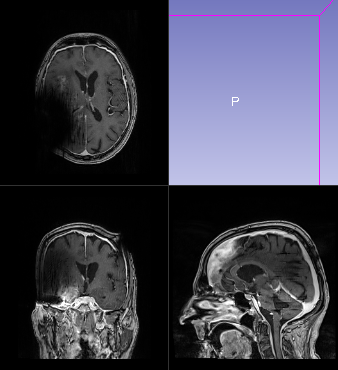

In [9]:
slicer.mrmlScene.Clear(False)
file_num = 1
vol_file, seg_file = failed_seg_files[file_num]
file_id = split(vol_file)[1][:6]

slicer.util.loadVolume(vol_file)
slicernb.ViewDisplay()
#slicer.util.loadSegmentation(seg_file)
#slicernb.ViewSliceDisplay(positionPercent=5,viewName='Yellow')
#slicernb.ViewLightboxDisplay( positionRange=[40,45])

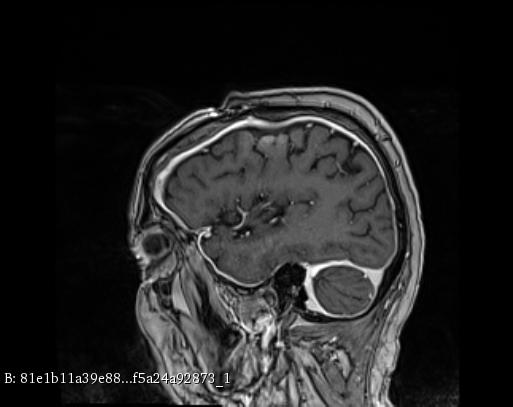

In [8]:
dcm_dir = dir_dic[inv_id_map[file_id]]
dcms = os.listdir(dcm_dir)
dcm_file = join(dcm_dir, dcms[int(len(dcms)/2)])

slicer.util.loadVolume(dcm_file)
#slicer.util.loadSegmentation(seg_file)
slicernb.ViewSliceDisplay(positionPercent=50, viewName='Yellow')

In [7]:
text = str(file_id) + ' something' + '\n'
Appendtext(log_file, text)